# 3 Train

In [40]:
import numpy as np
from skimage import io
from keras.models import Model, load_model
from keras.applications import inception_v3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import losses, optimizers
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)

## Load Data

In [41]:
# Load data
X_train, y_train = np.load('./data/X_train.npy'), np.load('./data/y_train.npy')
X_val, y_val = np.load('./data/X_val.npy'), np.load('./data/y_val.npy')
X_test, y_test = np.load('./data/X_test.npy'), np.load('./data/y_test.npy')
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_val.shape:', X_val.shape)
print('y_val.shape:', y_val.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (2992, 448, 448, 3)
y_train.shape: (2992,)
X_val.shape: (997, 448, 448, 3)
y_val.shape: (997,)
X_test.shape: (1000, 448, 448, 3)
y_test.shape: (1000,)


## Preprocess

In [42]:
# Preprocess function
def preprocess_im(im):
    im = im.astype(np.float32)
    im = inception_v3.preprocess_input(im)
    return im

# Preprocess validation
X_val = inception_v3.preprocess_input(X_val.astype(np.float32))

# Preprocess y
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

## Build Model

In [43]:
# ** Make model **
# Base model
base_model = inception_v3.myInceptionV3(weights='imagenet', include_top=False, input_shape=(448, 448, 3))
# base_model = inception_v3.myInceptionV3(weights='imagenet', include_top=False, input_shape=(499, 499, 3))
# Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.33)(x)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

AttributeError: module 'keras.applications.inception_v3' has no attribute 'myInceptionV3'

In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 499, 499, 3)  0                                            
__________________________________________________________________________________________________
conv2d_750 (Conv2D)             (None, 249, 249, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_750 (BatchN (None, 249, 249, 32) 96          conv2d_750[0][0]                 
__________________________________________________________________________________________________
activation_749 (Activation)     (None, 249, 249, 32) 0           batch_normalization_750[0][0]    
__________________________________________________________________________________________________
conv2d_751

                                                                 activation_817[0][0]             
                                                                 activation_818[0][0]             
__________________________________________________________________________________________________
conv2d_822 (Conv2D)             (None, 29, 29, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
batch_normalization_822 (BatchN (None, 29, 29, 192)  576         conv2d_822[0][0]                 
__________________________________________________________________________________________________
activation_821 (Activation)     (None, 29, 29, 192)  0           batch_normalization_822[0][0]    
__________________________________________________________________________________________________
conv2d_823 (Conv2D)             (None, 29, 29, 192)  258048      activation_821[0][0]             
__________

## Train Top Model

In [6]:
# ** Configuation **
# Freeze layers (Only top trainable)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
loss = losses.categorical_crossentropy
optimizer = optimizers.Adam()
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Callbacks
m_q = 'val_loss'
model_path = './models/model_foodvsnot_v2.h5'
check_pt = callbacks.ModelCheckpoint(filepath=model_path, monitor=m_q, save_best_only=True, verbose=1)
early_stop = callbacks.EarlyStopping(patience=1, monitor=m_q, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(patience=0, factor=0.33, monitor=m_q, verbose=1)
callback_list = [check_pt, early_stop, reduce_lr]


# ** Fit **
# Data Generator
datagen = ImageDataGenerator(horizontal_flip=True,  
                             rotation_range=15,
                             fill_mode='reflect',                          
                             preprocessing_function=preprocess_im)


# Batch size
batch_size = 64

# Fit
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),  
                    epochs=99,
                    steps_per_epoch=len(X_train)/batch_size,
                    callbacks=callback_list)                    
print('Top Model Train Done.')

87916544/87910968 [==============================] - 45s 1us/step
Epoch 1/99
 6/46 [==>...........................] - ETA: 34:20 - loss: 0.6568 - acc: 0.6250

KeyboardInterrupt: 

## Train All Model - Finetune

In [5]:
# Load the model
model = load_model('./models/model_foodvsnot_v2.h5')

In [6]:
# ** Configuation **
# Open layers
# for layer in model.layers[:249]:
#     layer.trainable = False
# for layer in model.layers[249:]:
#     layer.trainable = True
for layer in model.layers:
    layer.trainable = True

# Compile the model
loss = losses.categorical_crossentropy
optimizer = optimizers.SGD(lr=0.001, momentum=0.9)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Callbacks
m_q = 'val_loss'
model_path = './models/model_foodvsnot_v2.h5'
check_pt = callbacks.ModelCheckpoint(filepath=model_path, monitor=m_q, save_best_only=True, verbose=1)
early_stop = callbacks.EarlyStopping(patience=1, monitor=m_q, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(patience=0, factor=0.33, monitor=m_q, verbose=1)
callback_list = [check_pt, early_stop, reduce_lr]


# ** Fit **
# Data Generator
datagen = ImageDataGenerator(horizontal_flip=True,  
                             rotation_range=15,
                             fill_mode='reflect',                          
                             preprocessing_function=preprocess_im)


# Batch size
batch_size = 64

# Fit
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),  
                    epochs=99,
                    steps_per_epoch=len(X_train)/batch_size,
                    callbacks=callback_list)                    
print 'All Model Train Done.'

Epoch 1/99
46/46 [==============================] - 51s - loss: 0.0754 - acc: 0.9755 - val_loss: 0.0588 - val_acc: 0.9779
Epoch 2/99
46/46 [==============================] - 39s - loss: 0.0356 - acc: 0.9890 - val_loss: 0.0543 - val_acc: 0.9809
Epoch 3/99
46/46 [==============================] - 39s - loss: 0.0265 - acc: 0.9925 - val_loss: 0.0508 - val_acc: 0.9799
Epoch 4/99
46/46 [==============================] - 39s - loss: 0.0218 - acc: 0.9951 - val_loss: 0.0413 - val_acc: 0.9840
Epoch 5/99
46/46 [==============================] - 39s - loss: 0.0138 - acc: 0.9959 - val_loss: 0.0398 - val_acc: 0.9829
Epoch 6/99
46/46 [==============================] - 39s - loss: 0.0143 - acc: 0.9958 - val_loss: 0.0367 - val_acc: 0.9840
Epoch 7/99
45/46 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9979Epoch 00006: val_loss did not improve

Epoch 00006: reducing learning rate to 0.000330000015674.
46/46 [==============================] - 39s - loss: 0.0094 - acc: 0.9980 - val_los

## Find Optimal Threshold

Find optimal threshold by using validation data

In [3]:
# Load model
model = load_model('./models/model_foodvsnot.h5')

In [4]:
# Predict validation data
p_val = model.predict(inception_v3.preprocess_input(X_val.astype(np.float32)), verbose=1)

997/997 [==============================] - 5s     


Optimum Threshold: 0.766766766767
Max. Accuracy: 0.98294884654


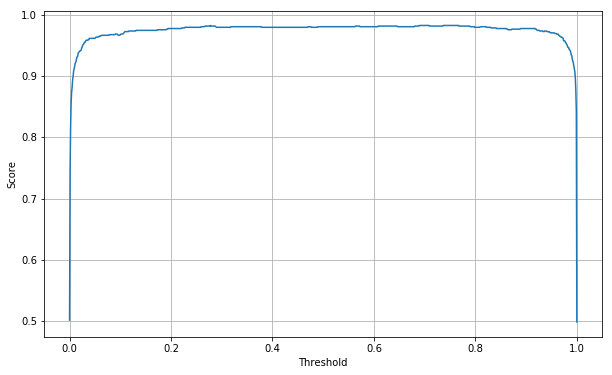

In [15]:
# Calculate thresholds and accuracies
thresholds = np.linspace(0, 1, 1000)
accuracies = [np.mean(y_val == (p_val[:, 1] > t).astype(np.int)) for t in thresholds]
# f1_scores = [metrics.f1_score(y_val, (p_val[:, 1] > t)) for t in thresholds]
# Find optimum threshold
optimum_pair = sorted(zip(thresholds, accuracies), key=lambda x: x[1])[-1]
print 'Optimum Threshold:', optimum_pair[0]
print 'Max. Accuracy:', optimum_pair[1]

# Plot
fig = plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies)
# plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold');
plt.ylabel('Score');
plt.grid('on')